# Dictionaries vs. `pandas.DataFrames` lookup times
We explore the time complexity of lookups in plain python `dicts` and `pandas.DataFrames`.

Dictionary lookup should be $\mathcal{O}(1)$. I expect that `pandas.DataFrame(...).loc[index, col]` is also much better than $\mathcal{O}(n)$, but with some additional overhead compared to plain `dict`.

The context for this, as we'll see in the example, is finding an efficent lookup method for all the [geomagnetic Kp-index](http://www.gfz-potsdam.de/en/section/earths-magnetic-field/data-products-services/kp-index/explanation/) data which may be held in memory. The index is 3-hourly and it begins in 1932-01-01, thus the full dataset would be $\sim2.5\times10^5$ samples.

There is a seperate issue of wheter this is faster than upsampling $Kp$.  



[Caveats: this is nothing like rigorous algorithmic analysis; it is not even proper profiling, just based on `ipython` `timeit` magic, there is a good probabiliy of intermediate result cacheing messing up timings]

In [1]:
%matplotlib inline
import random
import timeit

import matplotlib
import numpy as np
import pandas as pd

matplotlib.rcParams.update({'font.size': 16})

functions to define and manipulate a $Kp$-like index

In [2]:
def possible_kp_strs():
    """
    all possible Kp strings like:
    '0o', '0+', '1-', '1o', ..., '9o'
    """
    poss_kp = ''.join('{0}- {0}o {0}+ '.format(n) for n in range(0, 10))
    poss_kp = poss_kp.split()
    poss_kp = poss_kp[1:-1]  # '0-' and '9+' do not exist
    return poss_kp


_ALL_KPS = possible_kp_strs()

def random_kp():
    """an random sample for space of possible Kps"""
    return random.choice(_ALL_KPS)

functions for preparing a `dict` and `DataFrame` of the same data.

In [3]:
def date_index(num_periods=100):
    """
    a collection of datetimes
    for use as the `dict`'s keys or
    the pandas object's index
    """
    start = '1999-12-25'
    freq = 'S'
    return pd.date_range(start=start, periods=num_periods, freq=freq)


def tseries_dict(datetimes):
    """
    a datetime-keyed `dict` whose values are Kps
    
    the `dict_.keys()` will be the input `datetimes`
    """
    return {t: random_kp() for t in datetimes}

def tseries_pandas(tseries_dict):
    """
    pandas timeseries (DataFrame) based on a 
    time-keyed dictionary `tseries_dict`
    """
    return pd.DataFrame.from_dict(tseries_dict,
                                  orient='index').rename(columns={0: 'kp'})


def dict_and_pd_data(num_samples):
    """
    give me a time-keyed `dict`
    and a `pandas.DataFrame`
    with the same (Kp) data
    """
    times = date_index(num_samples)
    dict_ = tseries_dict(times)
    pdseries = tseries_pandas(dict_)
    return dict_, pdseries

------------------------------------------------------------------
## timings
Here, we actually run things to do the timings

In [4]:
nums_of_elems = np.logspace(start=0, stop=24, num=25, base=2)

# this will hold our results
lookup_times = pd.DataFrame(index=nums_of_elems,
                            columns=('dict_', 'pandas'))
# timings loop
for n_elems in nums_of_elems:
    dict_, frame = dict_and_pd_data(n_elems)
    atime = random.choice(frame.index)  # random time with which to do the lookup
    time_pd = %timeit -n5 -o frame.loc[atime, 'kp'];
    time_dict = %timeit -n5 -o dict_[atime];
    lookup_times.loc[n_elems, 'dict_'] = time_dict.best
    lookup_times.loc[n_elems, 'pandas'] = time_pd.best
print('done')

5 loops, best of 3: 167 µs per loop
The slowest run took 4.00 times longer than the fastest. This could mean that an intermediate result is being cached.
5 loops, best of 3: 423 ns per loop
5 loops, best of 3: 154 µs per loop
5 loops, best of 3: 423 ns per loop
5 loops, best of 3: 164 µs per loop
5 loops, best of 3: 423 ns per loop
5 loops, best of 3: 156 µs per loop
5 loops, best of 3: 423 ns per loop
5 loops, best of 3: 168 µs per loop
5 loops, best of 3: 362 ns per loop
5 loops, best of 3: 161 µs per loop
5 loops, best of 3: 423 ns per loop
5 loops, best of 3: 155 µs per loop
5 loops, best of 3: 423 ns per loop
5 loops, best of 3: 162 µs per loop
5 loops, best of 3: 423 ns per loop
5 loops, best of 3: 165 µs per loop
5 loops, best of 3: 423 ns per loop
5 loops, best of 3: 156 µs per loop
5 loops, best of 3: 423 ns per loop
5 loops, best of 3: 157 µs per loop
5 loops, best of 3: 423 ns per loop
5 loops, best of 3: 155 µs per loop
5 loops, best of 3: 423 ns per loop
5 loops, best of 3

In [7]:
lookup_times

,dict_,pandas
1.0,4.22589e-07,0.000167285
2.0,4.22589e-07,0.000153883
4.0,4.22589e-07,0.000164448
8.0,4.22589e-07,0.000155694
16.0,3.62219e-07,0.000167889
32.0,4.22589e-07,0.000161429
64.0,4.22589e-07,0.000155211
128.0,4.22589e-07,0.000161791
256.0,4.22589e-07,0.000164749
512.0,4.22589e-07,0.000155815


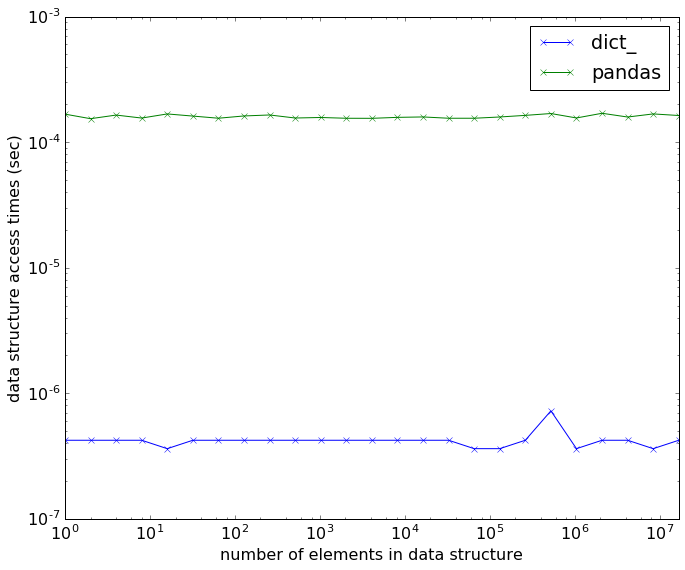

In [8]:
ax = lookup_times.plot(logy=True, logx=True, figsize=(11, 9), marker='x')
ax.set_ylabel('data structure access times (sec)')
ax.set_xlabel('number of elements in data structure')